In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root

In [24]:
R1 = 0.2
R2 = 8
r = np.linspace(R1, R2, 10000)
dr = (np.max(r)-np.min(r))/(len(r)-1)


In [25]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

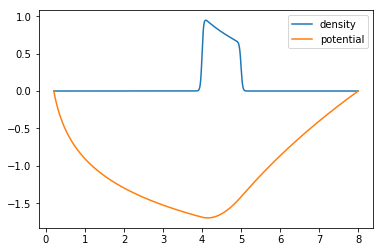

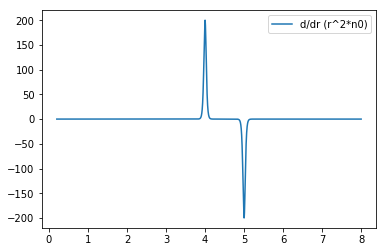

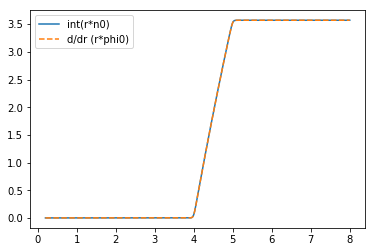

In [26]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
phi = lu.solve(n0)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

plt.plot(r, dn0, label='d/dr (r^2*n0)')
plt.legend()
plt.show()

plt.plot(r, in0, label='int(r*n0)')
plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
plt.legend()
plt.show()

In [27]:
def shooting(r, dr, dn0, in0, omega):
    @njit(parallel = True)
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
            diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[-0.75635284,  0.65416388],
       [-0.65416388, -0.75635284]])
     fun: array([-2.54126510e-07, -1.79104919e-07])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-1.36711406e-05,  2.93222180e-05])
       r: array([-101796.82952024,     358.14042937, -101392.77825326])
  status: 1
 success: True
       x: array([1.99181  , 0.6665016])
[0.995905  0.3332508]


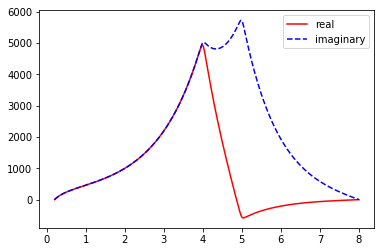

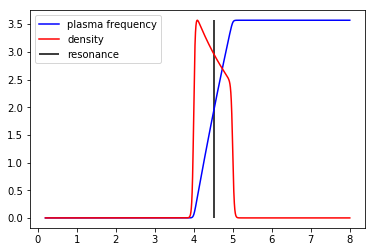

In [28]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [29]:
print((omega[0]/2-0.9949)/(omega[0]/2), (omega[1]/2-0.3342)/(omega[1]/2),omega[0]/2, omega[1]/2)

0.001009132471765822 -0.002848303993135704 0.995905000074369 0.3332508004144638


In [30]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

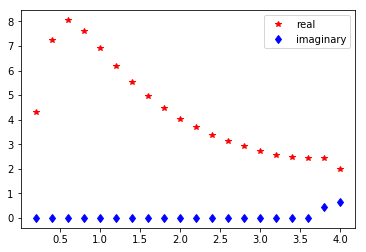

In [31]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.legend()
plt.show()

    fjac: array([[-0.70706819,  0.70714537],
       [-0.70714537, -0.70706819]])
     fun: array([192987.93193028, 192987.43233853])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 16
     qtf: array([ 1.42029931e+01, -2.72925878e+05])
       r: array([-5.59703456e-01,  5.72156363e-02,  2.90998392e-04])
  status: 5
 success: False
       x: array([ 488.33340744, 3277.20779814])
[ 244.16670372 1638.60389907]


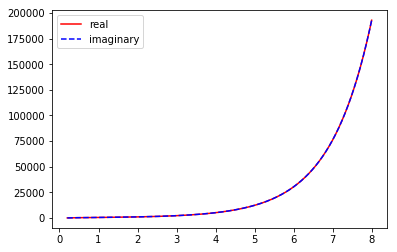

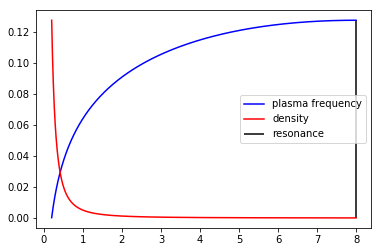

In [32]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

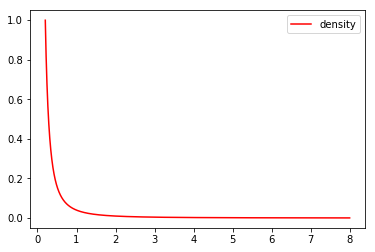

0.0


In [33]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])